# Demo - Siren

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [2]:
import numpy as np
import torch
from torch import nn
from tqdm.notebook import tqdm as tqdm
import os, imageio

from inr4ssh._src.models.siren import Siren, SirenNet, Modulator, ModulatedSirenNet
from inr4ssh._src.models.activations import Sine
from inr4ssh._src.data.images import load_fox
from inr4ssh._src.features.coords import get_image_coordinates
from inr4ssh._src.datamodules.images import ImageFox, ImageCameraman
from torch.nn import ReLU
import pytorch_lightning as pl
from inr4ssh._src.models.image import ImageModel
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.utilities.argparse import add_argparse_args
from pytorch_lightning.loggers import WandbLogger

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

In [3]:
img = load_fox()

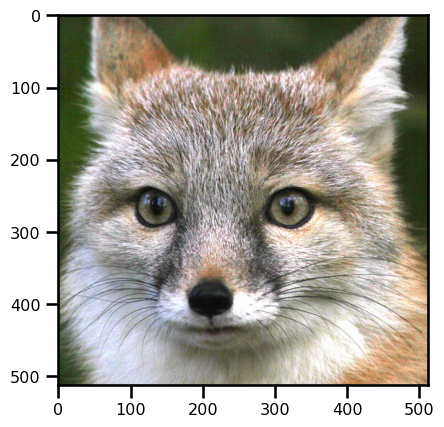

In [4]:
plt.figure()
plt.imshow(img)
plt.show()

### Data Module

In [5]:
dm = ImageFox(batch_size=4096).setup()
# dm = ImageCameraman(batch_size=4096).setup()

In [6]:
len(dm.ds_train)

131072

In [7]:
X_train, y_train = dm.ds_train[:]
X_valid, y_valid = dm.ds_valid[:]
X_test, y_test = dm.ds_test[:]
X_train = torch.cat([X_train, X_valid])
y_train = torch.cat([y_train, y_valid])

## Siren Net


### Sine Activation Layer

In [8]:
init = dm.ds_train[:32]
x_init, y_init = init
x_init.shape, y_init.shape

(torch.Size([32, 2]), torch.Size([32, 3]))

In [9]:
out = Sine()(x_init)

out.shape

torch.Size([32, 2])

### Siren Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sin\left(\omega_0 \left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)\right)
$$

In [10]:
dim_in = x_init.shape[1]
dim_out = y_init.shape[1]
w0 = 1.0
c = 6.0

layer = Siren(
    dim_in=dim_in, dim_out=dim_out, 
    w0=w0, c=c, 
)

In [11]:
out = layer(x_init)

### Siren Network

In [21]:
dim_in = x_init.shape[1]
dim_hidden = 256
dim_out = y_init.shape[1]
num_layers = 4
w0 = 1.0
w0_initial = 30.0
c = 6.0
final_activation = nn.Sigmoid()

siren_net = SirenNet(
    dim_in=dim_in, dim_hidden=dim_hidden, dim_out=dim_out,
    num_layers=num_layers,
    w0=w0, w0_initial=w0_initial,
    final_activation=final_activation
)

In [22]:
out = siren_net(x_init)

In [23]:
siren_net

SirenNet(
  (layers): ModuleList(
    (0): Siren(
      (activation): Sine()
    )
    (1): Siren(
      (activation): Sine()
    )
    (2): Siren(
      (activation): Sine()
    )
    (3): Siren(
      (activation): Sine()
    )
  )
  (last_layer): Siren(
    (activation): Sigmoid()
  )
)

## Training

In [24]:
if torch.has_mps:
    device = "mps"
elif torch.has_cuda:
    device = "cuda"
else:
    device = "cpu"

### Optimization

In [25]:
from skorch.callbacks import EarlyStopping, LRScheduler

In [26]:
# learning rate scheduler
lr_scheduler = LRScheduler(
    policy="ReduceLROnPlateau",
    monitor="valid_loss",
    mode="min",
    factor=0.1,
    patience=5,
)
# learning rate scheduler
# lr_scheduler = LRScheduler(
#     policy="CosineAnnealingWarmUpLR",
#     monitor="valid_loss",
#     mode="min",
#     factor=0.1,
#     patience=5,
# )

# early stopping
estop_callback = EarlyStopping(
    monitor="valid_loss", 
    patience=10,
)

callbacks = [
    ("earlystopping", estop_callback),
    ("lrscheduler", lr_scheduler),
]

In [27]:
from skorch.dataset import ValidSplit

# train split percentage
train_split = ValidSplit(0.5, stratified=False)

### Model Wrapper

In [28]:
from skorch import NeuralNetRegressor

skorch_net = NeuralNetRegressor(
    module=siren_net,
    max_epochs=200,
    lr=0.01,
    batch_size=4096,
    device=device,
    optimizer=torch.optim.Adam,
    train_split=train_split,
    callbacks=callbacks,
    iterator_train__num_workers=2,

)

In [29]:
skorch_net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0321        0.0132  7.5956
      2        0.0122        0.0117  7.5604


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SirenNet(
    (layers): ModuleList(
      (0): Siren(
        (activation): Sine()
      )
      (1): Siren(
        (activation): Sine()
      )
      (2): Siren(
        (activation): Sine()
      )
      (3): Siren(
        (activation): Sine()
      )
    )
    (last_layer): Siren(
      (activation): Sigmoid()
    )
  ),
)

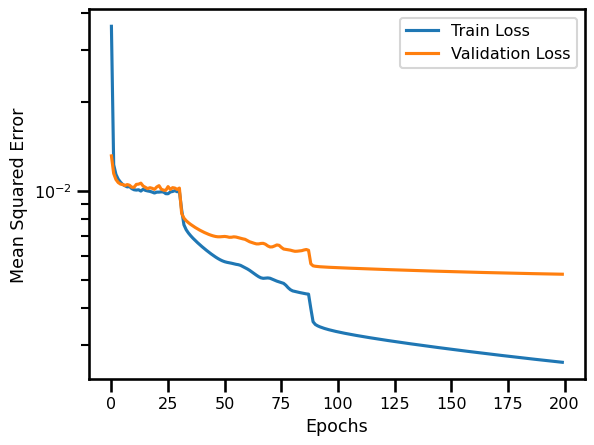

In [71]:
fig, ax = plt.subplots()

ax.plot(skorch_net.history[:, "train_loss"], label="Train Loss")
ax.plot(skorch_net.history[:, "valid_loss"], label="Validation Loss")

ax.set(yscale="log", xlabel="Epochs", ylabel="Mean Squared Error")

plt.legend()
plt.show()

In [72]:
y_pred = skorch_net.predict(X_test)

In [73]:
img_pred = dm.coordinates_2_image(y_pred)

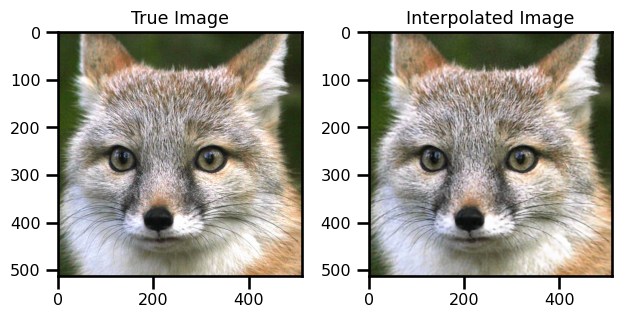

In [74]:
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(img, cmap="gray",)
axs[0].set_title("True Image")
axs[1].imshow(img_pred, cmap="gray",)
axs[1].set_title("Interpolated Image")
plt.tight_layout()
plt.show()

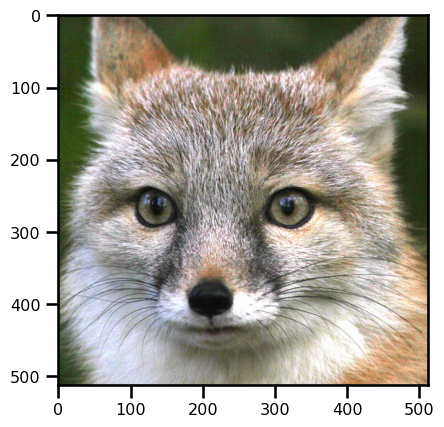

In [296]:
plt.figure()
plt.imshow(img, cmap="gray")
plt.show()

In [46]:
img_pred = dm.coordinates_2_image(y_pred)

EinopsError:  Error while processing rearrange-reduction pattern "(h w) c -> h w c".
 Input tensor shape: (131072, 1). Additional info: {'h': 512, 'w': 512}.
 Shape mismatch, 131072 != 262144

## Experiment

In [32]:
import pytorch_lightning as pl
pl.seed_everything(123)

Global seed set to 123


123

#### Dataset



In [44]:
learning_rate = 1e-4
siren_net = SirenNet(
    dim_in=dim_in, dim_hidden=dim_hidden, dim_out=dim_out,
    num_layers=num_layers,
    w0=w0, w0_initial=w0_initial,
    final_activation=final_activation,
)
dm = ImageFox(batch_size=4096).setup()

In [34]:
learn = ImageModel(siren_net, learning_rate=learning_rate)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [35]:
callbacks = [
    TQDMProgressBar(refresh_rate=100)
]

In [36]:
trainer = Trainer(
    min_epochs=1,
    max_epochs=100,
    accelerator="mps",
    enable_progress_bar=True,
    logger=None,
    callbacks=callbacks,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [37]:
trainer.fit(learn, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.train_dataloader())

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /Users/eman/code_projects/inr4ssh/notebooks/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type     | Params
-----------------------------------
0 | model | SirenNet | 198 K 
1 | loss  | MSELoss  | 0     
-----------------------------------
198 K     Trainable params
0         Non-trainable params
198 K     Total params
0.796     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([4096, 1])) that is different to the input size (torch.Size([4096, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many work

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [35]:
trainer.test(learn, dataloaders=dm.test_dataloader())

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.08347434550523758    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.08347434550523758}]

In [38]:
# t0 = time.time()
predictions = trainer.predict(learn, dataloaders=dm, return_predictions=True)
predictions = torch.cat(predictions)
# t1 = time.time() - t0

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 23it [00:00, ?it/s]

In [39]:
predictions.shape

torch.Size([262144, 3])

In [40]:
predictions.min(), predictions.max()

(tensor(0.0126), tensor(0.9265))

In [41]:
from einops import rearrange

In [42]:
img_pred = dm.coordinates_2_image(predictions)

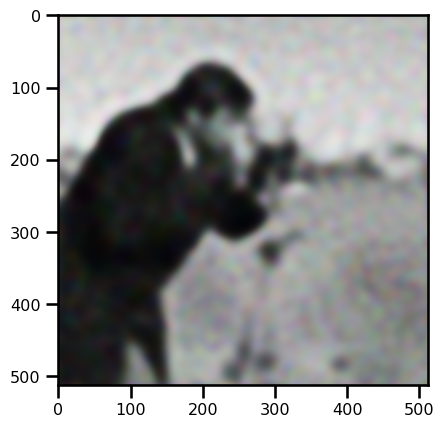

In [43]:
plt.figure()
plt.imshow(img_pred, cmap="gray")
plt.show()